In [ ]:
!pip install gym[box2d]
!pip install gym[atari]
!pip install gym[classic_control]
!pip install gym[accept-rom-license]
!pip install ale_py
!pip install pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 1.1 MB/s 
     |████████████████████████████████| 2.1 MB 54.3 MB/s 
     |████████████████████████████████| 1.8 MB 43.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441026 sha256=2403d78d56b2a6593d3d5639535436731326b7ff140833acf835c2f8d8ebe90f
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/

In [ ]:

import time
import argparse
import gym
import numpy as np
from collections import deque
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

#Problem 1
###(1) (a)

In [ ]:
 def randomGame(env, episodes):
    random_reward_array = []
    for episode in range(episodes):
        env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, info = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        random_reward_array.append(total)
        #print('Episode : {}, score : {}'.format(episode, total))
    #print(list(range(episodes)))
    #print(random_reward_array)
    plt.plot(list(range(episodes)), random_reward_array, '-go')
    plt.xlabel('episodes')
    plt.ylabel('total reward')
    #plt.legend()
    plt.show()

In [ ]:
env1 = gym.make('MountainCarContinuous-v0')
print(env1.observation_space.shape)
print(env1.action_space)

(2,)
Box(-1.0, 1.0, (1,), float32)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
env2 = gym.make('LunarLanderContinuous-v2')
print(env2.observation_space.shape)
print(env2.action_space)

(8,)
Box(-1.0, 1.0, (2,), float32)


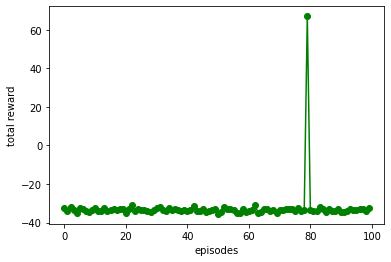

In [ ]:
randomGame(env1, 100)

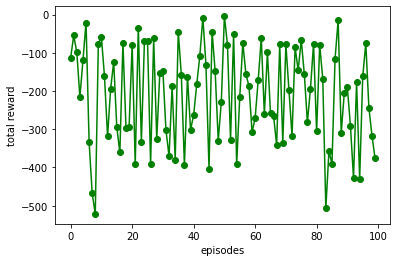

In [ ]:
randomGame(env2, 100)

### (1) (b)

In [ ]:
class Memory(object):
    def __init__(self, memory_size=10000):
        self.memory = deque(maxlen=memory_size)
        self.memory_size = memory_size

    def __len__(self):
        return len(self.memory)

    def append(self, item):
        self.memory.append(item)

    def sample_batch(self, batch_size):
        idx = np.random.permutation(len(self.memory))[:batch_size]
        return [self.memory[i] for i in idx]

class critic(torch.nn.Module):
    def __init__(self, in_channels=2, out_channels = 1):
        super(critic, self).__init__()
        self.fc_state = nn.Linear(in_channels, 32)
        self.fc_action = nn.Linear(out_channels, 32)
        self.fc = nn.Linear(64, 128)
        self.fc_value = nn.Linear(128, 1, bias=False)
        
    def forward(self, state, action):
        out_s = F.relu(self.fc_state(state))
        #print("out_s : ", out_s.shape)
        out_a = F.relu(self.fc_action(action))
        #print("out_a : ", out_a.shape)
        out = torch.cat([out_s, out_a], dim=1)
        out = F.relu(self.fc(out))
        out = self.fc_value(out)
        return out

class actor(nn.Module):
    def __init__(self, in_channels=2, out_channels = 1):
        super(actor, self).__init__()
        self.fc_1 = nn.Linear(in_channels, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, out_channels, bias=False)

    def forward(self, x):
        out = F.relu(self.fc_1(x))
        out = F.relu(self.fc_2(out))
        out = F.tanh(self.fc_out(out))
        return out

class network():
    def __init__(self, env, game, gamma = 0.99, lr = 1e-4, tau = 0.001,max_explore_eps = 200, max_episodes = 200, batch_size = 64, buffer_size = 10000):
        self.env = env
        self.game = game
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.batch_size = batch_size
        self.max_episodes = max_episodes
        self.max_explore_eps = max_explore_eps
        if game == 'MountainCarContinuous-v0':
            self.actor = actor()
            self.critic = critic()
        elif game == 'LunarLanderContinuous-v2':
            self.actor = actor(in_channels = 8, out_channels = 2)
            self.critic = critic(in_channels = 8, out_channels = 2)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory(memory_size=buffer_size)

    def oUNoise(self):
        theta = 0.15
        sigma = 0.3
        mu = 0
        state = 0
        while True:
            yield state
            state += theta * (mu - state) + sigma * np.random.randn()

    def gaussianNoise(self):
        sigma = 0.3
        state = 0
        while True:
            yield state
            state += sigma * np.random.randn()
    
    def getQValue(self, _critic, state, action):
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state).float()
        if not isinstance(action, torch.Tensor):
            action = torch.from_numpy(action).float()
        q_value = _critic(state, action)
        return q_value

    def updateActor(self, state):
        action = self.actor(state)
        action = torch.clamp(action, float(self.env.action_space.low[0]), float(self.env.action_space.high[0]))
        # using chain rule to calculate the gradients of actor
        q_value = -torch.mean(self.critic(state, action))
        self.actor_optimizer.zero_grad()
        q_value.backward()
        self.actor_optimizer.step()
        return

    def updateCritic(self, state, action, target):
        #print(state.shape, action.shape)
        q_value = self.critic(state, action)
        loss = F.mse_loss(q_value, target)
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        return

    def softUpdate(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

    def getAction(self, _actor, state):
        if not isinstance(state, torch.Tensor):
          state = torch.from_numpy(state).float()
        action = _actor(state)
        #print("action : ", action)
        #print("action_space.low", self.env.action_space.low[0])
        action = torch.clamp(action, float(self.env.action_space.low[0]), float(self.env.action_space.high[0]))
        #print("action : ", action)
        return action

    def train(self, noise = 'OUNoise', memory_update_after = 200):
        state = self.env.reset()
        score_array = []
        if noise == 'OUNoise':
          noise = self.oUNoise()
        elif noise == 'GaussianNoise':
          noise = self.gaussianNoise()
        iteration = 0
        episode = 0
        episode_score = 0
        episode_steps = 0
        while episode < self.max_episodes:
            action = self.getAction(self.actor, state).detach().numpy()
            #print("action in train : ", action)

            # blend determinstic action with random action during exploration
            if episode < self.max_explore_eps:
                p = episode / self.max_explore_eps
                action = action * p + (1 - p) * next(noise)
            
            next_state, reward, done, _ = self.env.step(action)
            self.memory.append([state, action, reward, next_state, done])

            if iteration >= memory_update_after:
                memory_batch = self.memory.sample_batch(self.batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = map(lambda x: torch.tensor(x).float(), zip(*memory_batch))
                action_next = self.getAction(self.actor_target, next_state_batch)
                Q_next = self.getQValue(self.critic_target, next_state_batch, action_next).detach()
                Q_target_batch = reward_batch[:, None] + self.gamma * (1 - done_batch[:, None]) * Q_next
                #print("action_batch :", action_batch.shape)
                #self.updateCritic(state_batch, action_batch[:, None], Q_target_batch)
                self.updateCritic(state_batch, action_batch, Q_target_batch)
                self.updateActor(state_batch)

                self.softUpdate(self.actor_target, self.actor)
                self.softUpdate(self.critic_target, self.critic)

            episode_score += reward
            episode_steps += 1
            iteration += 1
            if done:
                print('episode : {}, steps {}, score {:8f}'.format(episode + 1, episode_steps,  episode_score))
                score_array.append(episode_score)
                episode += 1
                episode_score = 0
                episode_steps = 0
                state = self.env.reset()
                if noise == 'OUNoise':
                    noise = self.oUNoise()
                elif noise == 'GaussianNoise':
                    noise = self.gaussianNoise()
            else:
                state = next_state
        self.env.close()
        return score_array

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode : 1, steps 233, score 93.073598
episode : 2, steps 826, score 76.336774
episode : 3, steps 245, score 89.898415
episode : 4, steps 505, score 83.070510
episode : 5, steps 344, score 87.144370
episode : 6, steps 999, score -29.528061
episode : 7, steps 999, score -29.662760
episode : 8, steps 644, score 81.044611
episode : 9, steps 941, score 71.403202
episode : 10, steps 999, score -23.950775
episode : 11, steps 684, score 83.272402
episode : 12, steps 478, score 84.070154
episode : 13, steps 999, score -28.350685
episode : 14, steps 999, score -21.920630
episode : 15, steps 999, score -22.303947
episode : 16, steps 999, score -22.893437
episode : 17, steps 999, score -30.531586
episode : 18, steps 999, score -27.330195
episode : 19, steps 709, score 81.614933
episode : 20, steps 282, score 91.749207
episode : 21, steps 833, score 80.267419
episode : 22, steps 999, score -23.166951
episode : 23, steps 999, score -21.171298
episode : 24, steps 999, score -28.717439
episode : 25,

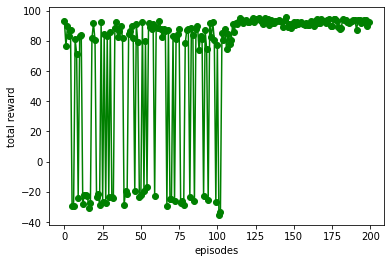

In [ ]:
model = network(env1, 'MountainCarContinuous-v0')
score_array = model.train()
plt.plot(range(len(score_array)), score_array, '-go')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

episode : 1, steps 81, score -402.243880
episode : 2, steps 87, score -348.979788
episode : 3, steps 100, score -204.199024
episode : 4, steps 75, score -151.603959
episode : 5, steps 93, score -455.076357
episode : 6, steps 116, score -192.742671
episode : 7, steps 68, score -588.080375
episode : 8, steps 78, score -479.860965
episode : 9, steps 86, score -378.588437
episode : 10, steps 84, score -212.851154
episode : 11, steps 98, score -355.177817
episode : 12, steps 87, score -210.457954
episode : 13, steps 90, score -94.418420
episode : 14, steps 59, score -175.457366
episode : 15, steps 117, score -282.167294
episode : 16, steps 58, score -179.439434
episode : 17, steps 54, score -109.748953
episode : 18, steps 139, score -113.116663
episode : 19, steps 147, score -711.141890
episode : 20, steps 95, score -105.838857
episode : 21, steps 172, score -258.363283
episode : 22, steps 72, score -332.914899
episode : 23, steps 78, score -205.673766
episode : 24, steps 67, score -409.914

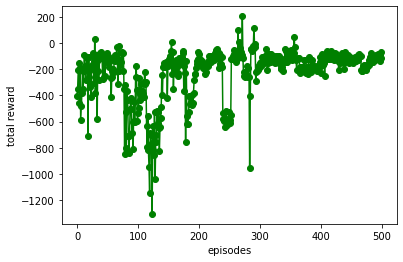

In [ ]:
model = network(env2, 'LunarLanderContinuous-v2', max_episodes = 500)
score_array = model.train()
plt.plot(range(len(score_array)), score_array, '-go')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

### (1) (c)
With gaussian noise to achieve good total reward, the number of episodes required are more than what OU Noise requires. This can be seen for both the environments of MountainCarContinuous-v0 and LunarLanderContinuous-v2.

episode : 1, steps 270, score 65.554976
episode : 2, steps 574, score -399.929477
episode : 3, steps 999, score -4404.075244
episode : 4, steps 999, score -8467.002880
episode : 5, steps 999, score -26764.293948
episode : 6, steps 999, score -21891.570742
episode : 7, steps 999, score -17933.223411
episode : 8, steps 999, score -5816.527141
episode : 9, steps 999, score -30533.214667
episode : 10, steps 999, score -73994.811944
episode : 11, steps 999, score -73035.489526
episode : 12, steps 999, score -45079.540931
episode : 13, steps 999, score -35901.986007
episode : 14, steps 999, score -73507.263606
episode : 15, steps 999, score -135517.336766
episode : 16, steps 999, score -142079.122043
episode : 17, steps 999, score -123958.786548
episode : 18, steps 999, score -129631.767197
episode : 19, steps 999, score -134927.453143
episode : 20, steps 999, score -110955.158496
episode : 21, steps 999, score -75075.111108
episode : 22, steps 999, score -74278.657817
episode : 23, steps 99

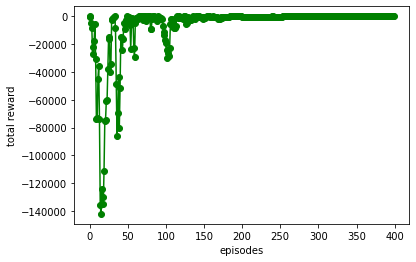

In [ ]:
model = network(env1, 'MountainCarContinuous-v0', max_episodes = 400)
score_array = model.train(noise = 'GaussianNoise')
plt.plot(range(len(score_array)), score_array, '-go')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode : 1, steps 74, score -516.787595
episode : 2, steps 58, score -293.585774
episode : 3, steps 50, score -342.815557
episode : 4, steps 73, score -498.792773
episode : 5, steps 76, score -474.255297
episode : 6, steps 102, score -1355.164421
episode : 7, steps 97, score -1209.993245
episode : 8, steps 128, score -1316.168528
episode : 9, steps 66, score -715.027700
episode : 10, steps 62, score -442.643698
episode : 11, steps 53, score -429.407047
episode : 12, steps 63, score -496.799535
episode : 13, steps 98, score -1354.412761
episode : 14, steps 111, score -659.680528
episode : 15, steps 69, score -815.366903
episode : 16, steps 96, score -1278.164700
episode : 17, steps 145, score -2237.955638
episode : 18, steps 96, score -1050.920458
episode : 19, steps 75, score -645.150196
episode : 20, steps 65, score -528.968098
episode : 21, steps 69, score -556.167445
episode : 22, steps 57, score -536.917307
episode : 23, steps 85, score -910.806074
episode : 24, steps 63, score -5

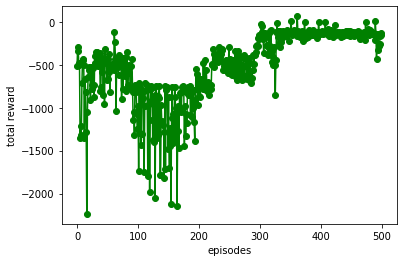

In [ ]:
model = network(env2, 'LunarLanderContinuous-v2', max_episodes = 500)
score_array = model.train(noise = 'GaussianNoise')
plt.plot(range(len(score_array)), score_array, '-go')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.show()

#Problem 2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

### (2) (a)

In [36]:
class bandit:
    def __init__(self, k, eps, iters, mu='random', eps_decay = 1, eps_min = 0.01, ucb_flag = False, explor_parm = 1):
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.explor_parm = explor_parm
        self.k = k
        self.eps = eps
        self.iters = iters
        self.n = 1
        self.k_n = np.ones(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.temp_reward = np.zeros(iters)
        self.temp_k_reward = np.zeros(k)
        self.k_reward = np.zeros(k)
        self.ucb_flag = ucb_flag
        self.avg_regret = 0
        self.explore_parm = 1
        
        if type(mu) == list or type(mu).__module__ == np.__name__:     
            self.mu = np.array(mu)
        elif mu == 'random':
            self.mu = np.random.normal(0, 1, k)
            #print(self.mu)
        
    def pull(self, i):
        if i < self.explore_parm*self.k:
            for m in range(self.k):
                reward = np.random.normal(self.mu[m], 1)
                self.n += 1
                self.k_n[m] += 1
                self.temp_k_reward[m] += reward
                self.temp_reward[m] = reward
                #self.avg_regret += np.max(self.k_reward)/self.k_n[np.argmax(self.k_reward)] - np.sum(self.temp_reward)/len(self.temp_reward)
                regret = self.temp_k_reward[np.argmax(self.temp_k_reward)]/self.k_n[np.argmax(self.temp_k_reward)] - np.sum(self.temp_reward)/len(self.temp_reward)
                self.avg_regret += regret
        else:
            if not self.ucb_flag:
                p = np.random.rand()
                if self.eps == 0 and self.n == 1:
                    a = np.random.choice(self.k)
                elif p < self.eps:
                    a = np.random.choice(self.k)
                else:
                    a = np.argmax(self.temp_k_reward/self.k_n)
                    """
                    a = np.argmax(self.k_reward)
                    """

                if self.eps > self.eps_min:
                    self.eps *= self.eps_decay
            else:
                a = np.argmax(self.temp_k_reward/self.k_n + np.sqrt((2 * np.log(self.n)) / self.k_n))
                """
                a = np.argmax(self.k_reward + self.explor_parm * np.sqrt((np.log(self.n)) / self.k_n))
                """
                
            reward = np.random.normal(self.mu[a], 1)
            
            # Update counts
            self.n += 1
            self.k_n[a] += 1

            """below code is for average reward as per question"""
            self.temp_k_reward[a] += reward
            self.temp_reward[i] = reward
            #self.avg_regret += np.max(self.k_reward)/self.k_n[np.argmax(self.k_reward)] - np.sum(self.temp_reward)/len(self.temp_reward)
            regret = self.temp_k_reward[np.argmax(self.temp_k_reward)]/self.k_n[np.argmax(self.temp_k_reward)] - np.sum(self.temp_reward)/len(self.temp_reward)
            self.avg_regret += regret

            """Below code for cumulative reward and smooth diagram"""
            self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
            
            # Update results for a_k
            self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull(i)
            self.reward[i] = self.mean_reward
            if i < self.explore_parm*self.k:
                i += self.k
            
    def reset(self, mu = 'random'):
        # Resets results while keeping settings
        self.n = 1
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)
        self.temp_k_reward = np.zeros(k)
        self.temp_reward = np.zeros(iters)
        self.avg_regret = 0
        if type(mu) == list or type(mu).__module__ == np.__name__:
            self.mu = np.array(mu)
        elif mu == 'random':
            self.mu = np.random.normal(0, 1, k)
            #print(self.mu)

### (2) (b)

In [43]:
k = 10
iters = 1000
episodes = 100

eps_0_rewards = np.zeros(iters, dtype=float)
eps_01_rewards = np.zeros(iters, dtype=float)
eps_1_rewards = np.zeros(iters, dtype=float)
eps_decay_995_rewards = np.zeros(iters, dtype=float)
ucb_rewards = np.zeros(iters, dtype=float)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_decay_995_selection = np.zeros(k)
ucb_selection = np.zeros(k)
eps_0_regrets = np.zeros(episodes, dtype=float)
eps_01_regrets = np.zeros(episodes, dtype=float)
eps_1_regrets = np.zeros(episodes, dtype=float)
eps_decay_995_regrets = np.zeros(episodes, dtype=float)
ucb_regrets = np.zeros(episodes, dtype=float)

mu = [-5, 10, -15, 20, -25, 30, -35, 40, -45, 50]

# Run experiments
for i in range(episodes):

    # eps_0 = bandit(k, eps = 0, iters = iters)
    # eps_01 = bandit(k, eps = 0.01, iters = iters)
    # eps_1 = bandit(k, eps = 0.1, iters = iters)
    # eps_decay_995 = bandit(k, eps = 0.4, iters = iters, eps_decay = 0.995)
    # ucb = bandit(k, eps = 0, iters = iters, ucb_flag = True, explor_parm = 2)

    eps_0 = bandit(k, eps = 0, iters = iters, mu = mu)
    eps_01 = bandit(k, eps = 0.01, iters = iters, mu = mu)
    eps_1 = bandit(k, eps = 0.1, iters = iters, mu = mu)
    eps_decay_995 = bandit(k, eps = 0.4, iters = iters, mu = mu, eps_decay = 0.995)
    ucb = bandit(k, eps = 0, iters = iters, mu = mu, ucb_flag = True, explor_parm = 2)
    
    eps_0.run()
    eps_01.run()
    eps_1.run()
    eps_decay_995.run()
    ucb.run()

    eps_0_rewards = eps_0_rewards + eps_0.temp_reward
    eps_01_rewards = eps_01_rewards + eps_01.temp_reward
    eps_1_rewards = eps_1_rewards + eps_1.temp_reward
    eps_decay_995_rewards = eps_decay_995_rewards + eps_decay_995.temp_reward
    ucb_rewards = ucb_rewards + ucb.temp_reward

    eps_0_selection = eps_0_selection + eps_0.k_n
    eps_01_selection = eps_01_selection + eps_01.k_n
    eps_1_selection = eps_1_selection + eps_1.k_n
    eps_decay_995_selection = eps_decay_995_selection + eps_decay_995.k_n
    ucb_selection = ucb_selection + ucb.k_n

    eps_0_regrets[i] = eps_0.avg_regret
    eps_01_regrets[i] = eps_01.avg_regret
    eps_1_regrets[i] = eps_1.avg_regret
    eps_decay_995_regrets[i] = eps_decay_995.avg_regret
    ucb_regrets[i] = ucb.avg_regret
    
    """
    #below is the code for cumulative smooth function
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)
    eps_decay_995_rewards = eps_decay_995_rewards + (eps_decay_995.reward - eps_decay_995_rewards) / (i + 1)
    ucb_rewards = ucb_rewards + (ucb.reward - ucb_rewards) / (i + 1)
    
    eps_0_selection = eps_0_selection + (eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (eps_1.k_n - eps_1_selection) / (i + 1)
    eps_decay_995_selection = eps_decay_995_selection + (eps_decay_995.k_n - eps_decay_995_selection) / (i + 1)
    ucb_selection = ucb_selection + (ucb.k_n - ucb_selection) / (i + 1)

    eps_0_regrets[i] = eps_0.avg_regret
    eps_01_regrets[i] = eps_01.avg_regret
    eps_1_regrets[i] = eps_1.avg_regret
    eps_decay_995_regrets[i] = eps_decay_995.avg_regret
    ucb_regrets[i] = ucb.avg_regret
    """

    # eps_0.reset()
    # eps_01.reset()
    # eps_1.reset()
    # eps_decay_995.reset()
    # ucb.reset()

    eps_0.reset(mu = mu)
    eps_01.reset(mu = mu)
    eps_1.reset(mu = mu)
    eps_decay_995.reset(mu = mu)
    ucb.reset(mu = mu)

eps_0_rewards = eps_0_rewards/episodes
eps_01_rewards = eps_01_rewards/episodes
eps_1_rewards = eps_1_rewards/episodes
eps_decay_995_rewards = eps_decay_995_rewards/episodes
ucb_rewards = ucb_rewards/episodes

eps_0_selection = eps_0_selection/episodes
eps_01_selection = eps_01_selection/episodes
eps_1_selection = eps_1_selection/episodes
eps_decay_995_selection = eps_decay_995_selection/episodes
ucb_selection = ucb_selection/episodes

eps_0_regrets = eps_0_regrets/iters
eps_01_regrets = eps_01_regrets/iters
eps_1_regrets = eps_1_regrets/iters
eps_decay_995_regrets = eps_decay_995_regrets/iters
ucb_regrets = ucb_regrets/iters

### (2) (c)

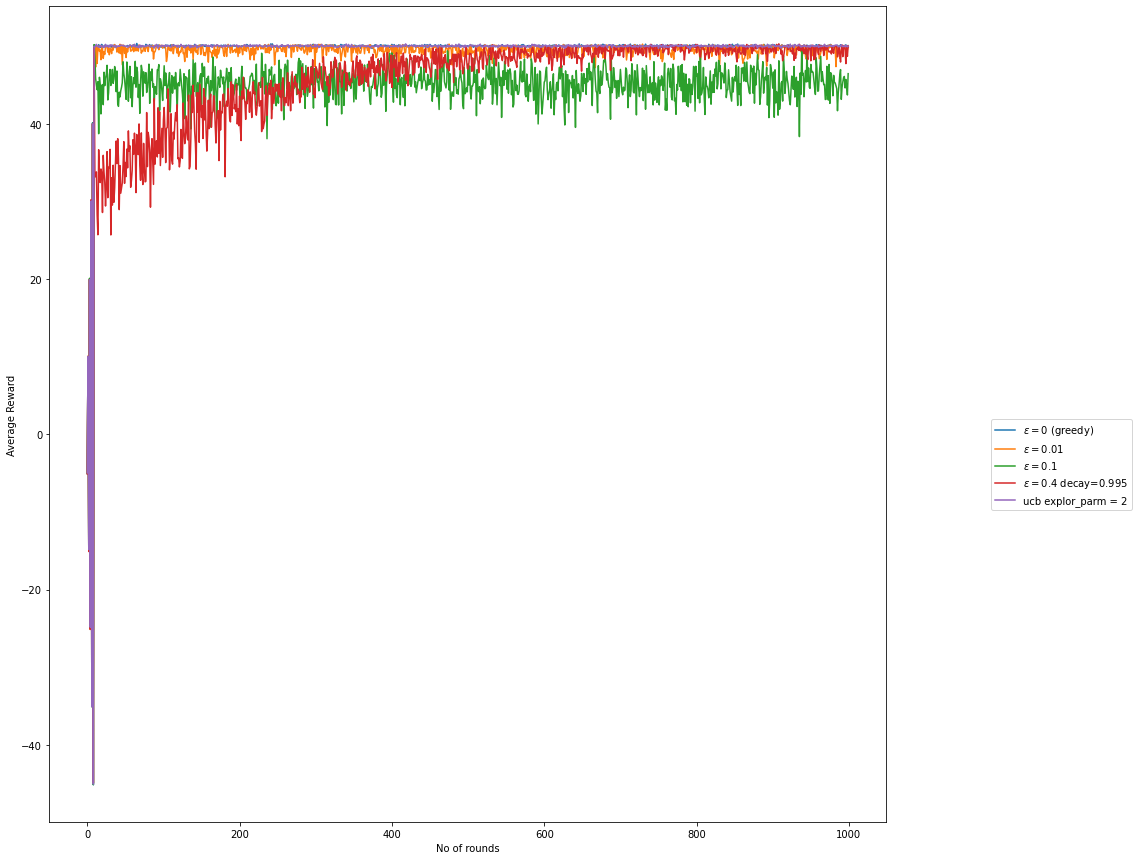

In [44]:
plt.figure(figsize=(15,15))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(eps_decay_995_rewards, label="$\epsilon=0.4$ decay=0.995")
plt.plot(ucb_rewards, label="ucb explor_parm = 2")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("No of rounds")
plt.ylabel("Average Reward")
plt.show()

### (2) (d)

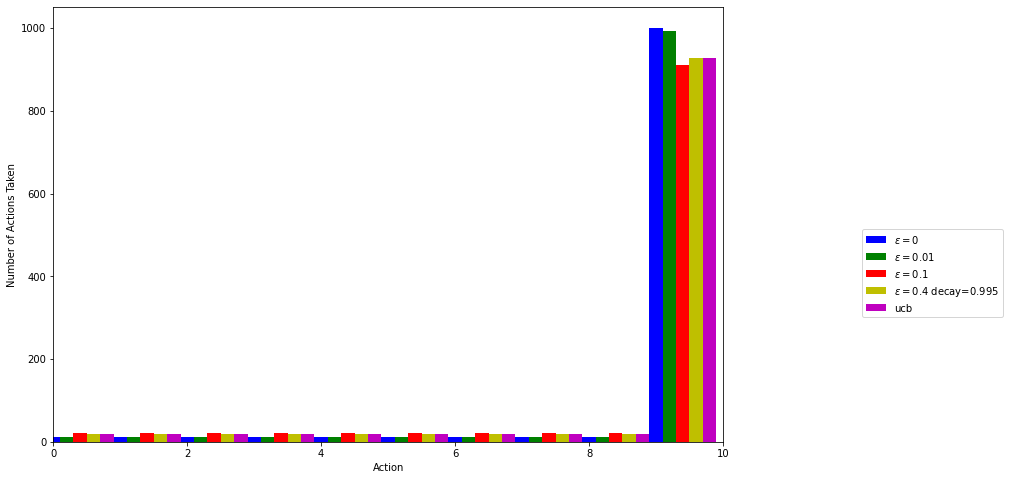

In [45]:
bins = np.linspace(0, k-1, k)
plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, width = 0.2, color='b', label="$\epsilon=0$")
plt.bar(bins+0.2, eps_01_selection, width=0.2, color='g', label="$\epsilon=0.01$")
plt.bar(bins+0.4, eps_1_selection, width=0.2, color='r', label="$\epsilon=0.1$")
plt.bar(bins+0.6, eps_decay_995_selection, width=0.2, color='y', label="$\epsilon=0.4$ decay=0.995")
plt.bar(bins+0.8, eps_decay_995_selection, width=0.2, color='m', label="ucb")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

### (2) (e)

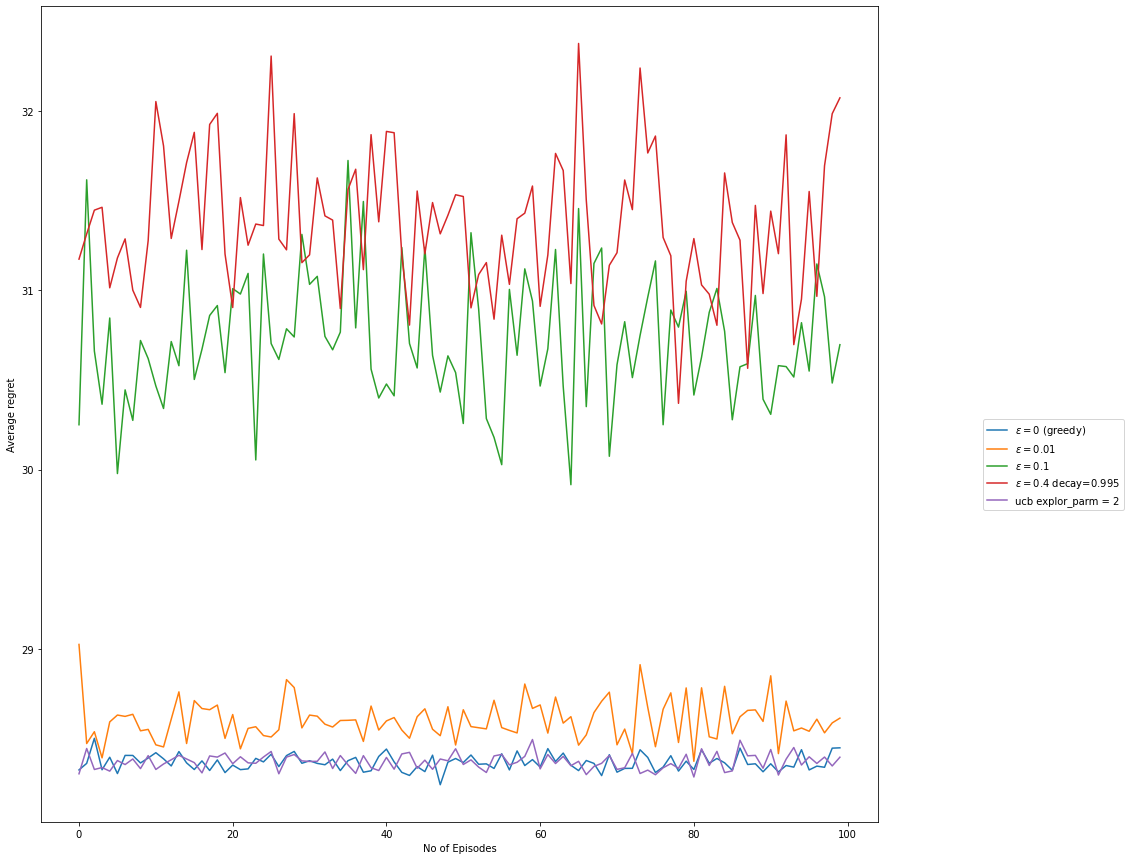

In [46]:
plt.figure(figsize=(15,15))
plt.plot(eps_0_regrets, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_regrets, label="$\epsilon=0.01$")
plt.plot(eps_1_regrets, label="$\epsilon=0.1$")
plt.plot(eps_decay_995_regrets, label="$\epsilon=0.4$ decay=0.995")
plt.plot(ucb_regrets, label="ucb explor_parm = 2")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("No of Episodes")
plt.ylabel("Average regret")
plt.show()

### (2) (f)
From the average reward to number of rounds plot we can see that ucb algorithm is performing good.

### (2) (g) 
If we choose ucb algorithm as best algorithm and check the mostly picked and second mostly picked arm then they are arm number 10 and 8, 
we can change the mean reward for arm number 8 to 49.99 and see what happens to all the plots. 

In [47]:
k = 10
iters = 1000
episodes = 100

eps_0_rewards = np.zeros(iters, dtype=float)
eps_01_rewards = np.zeros(iters, dtype=float)
eps_1_rewards = np.zeros(iters, dtype=float)
eps_decay_995_rewards = np.zeros(iters, dtype=float)
ucb_rewards = np.zeros(iters, dtype=float)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_decay_995_selection = np.zeros(k)
ucb_selection = np.zeros(k)
eps_0_regrets = np.zeros(episodes, dtype=float)
eps_01_regrets = np.zeros(episodes, dtype=float)
eps_1_regrets = np.zeros(episodes, dtype=float)
eps_decay_995_regrets = np.zeros(episodes, dtype=float)
ucb_regrets = np.zeros(episodes, dtype=float)

mu = [-5, 10, -15, 20, -25, 30, -35, 49.99, -45, 50]

# Run experiments
for i in range(episodes):

    # eps_0 = bandit(k, eps = 0, iters = iters)
    # eps_01 = bandit(k, eps = 0.01, iters = iters)
    # eps_1 = bandit(k, eps = 0.1, iters = iters)
    # eps_decay_995 = bandit(k, eps = 0.4, iters = iters, eps_decay = 0.995)
    # ucb = bandit(k, eps = 0, iters = iters, ucb_flag = True, explor_parm = 2)

    eps_0 = bandit(k, eps = 0, iters = iters, mu = mu)
    eps_01 = bandit(k, eps = 0.01, iters = iters, mu = mu)
    eps_1 = bandit(k, eps = 0.1, iters = iters, mu = mu)
    eps_decay_995 = bandit(k, eps = 0.4, iters = iters, mu = mu, eps_decay = 0.995)
    ucb = bandit(k, eps = 0, iters = iters, mu = mu, ucb_flag = True, explor_parm = 2)
    
    eps_0.run()
    eps_01.run()
    eps_1.run()
    eps_decay_995.run()
    ucb.run()

    eps_0_rewards = eps_0_rewards + eps_0.temp_reward
    eps_01_rewards = eps_01_rewards + eps_01.temp_reward
    eps_1_rewards = eps_1_rewards + eps_1.temp_reward
    eps_decay_995_rewards = eps_decay_995_rewards + eps_decay_995.temp_reward
    ucb_rewards = ucb_rewards + ucb.temp_reward

    eps_0_selection = eps_0_selection + eps_0.k_n
    eps_01_selection = eps_01_selection + eps_01.k_n
    eps_1_selection = eps_1_selection + eps_1.k_n
    eps_decay_995_selection = eps_decay_995_selection + eps_decay_995.k_n
    ucb_selection = ucb_selection + ucb.k_n

    eps_0_regrets[i] = eps_0.avg_regret
    eps_01_regrets[i] = eps_01.avg_regret
    eps_1_regrets[i] = eps_1.avg_regret
    eps_decay_995_regrets[i] = eps_decay_995.avg_regret
    ucb_regrets[i] = ucb.avg_regret
    
    """
    #below is the code for cumulative smooth function
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)
    eps_decay_995_rewards = eps_decay_995_rewards + (eps_decay_995.reward - eps_decay_995_rewards) / (i + 1)
    ucb_rewards = ucb_rewards + (ucb.reward - ucb_rewards) / (i + 1)
    
    eps_0_selection = eps_0_selection + (eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (eps_1.k_n - eps_1_selection) / (i + 1)
    eps_decay_995_selection = eps_decay_995_selection + (eps_decay_995.k_n - eps_decay_995_selection) / (i + 1)
    ucb_selection = ucb_selection + (ucb.k_n - ucb_selection) / (i + 1)

    eps_0_regrets[i] = eps_0.avg_regret
    eps_01_regrets[i] = eps_01.avg_regret
    eps_1_regrets[i] = eps_1.avg_regret
    eps_decay_995_regrets[i] = eps_decay_995.avg_regret
    ucb_regrets[i] = ucb.avg_regret
    """

    # eps_0.reset()
    # eps_01.reset()
    # eps_1.reset()
    # eps_decay_995.reset()
    # ucb.reset()

    eps_0.reset(mu = mu)
    eps_01.reset(mu = mu)
    eps_1.reset(mu = mu)
    eps_decay_995.reset(mu = mu)
    ucb.reset(mu = mu)

eps_0_rewards = eps_0_rewards/episodes
eps_01_rewards = eps_01_rewards/episodes
eps_1_rewards = eps_1_rewards/episodes
eps_decay_995_rewards = eps_decay_995_rewards/episodes
ucb_rewards = ucb_rewards/episodes

eps_0_selection = eps_0_selection/episodes
eps_01_selection = eps_01_selection/episodes
eps_1_selection = eps_1_selection/episodes
eps_decay_995_selection = eps_decay_995_selection/episodes
ucb_selection = ucb_selection/episodes

eps_0_regrets = eps_0_regrets/iters
eps_01_regrets = eps_01_regrets/iters
eps_1_regrets = eps_1_regrets/iters
eps_decay_995_regrets = eps_decay_995_regrets/iters
ucb_regrets = ucb_regrets/iters

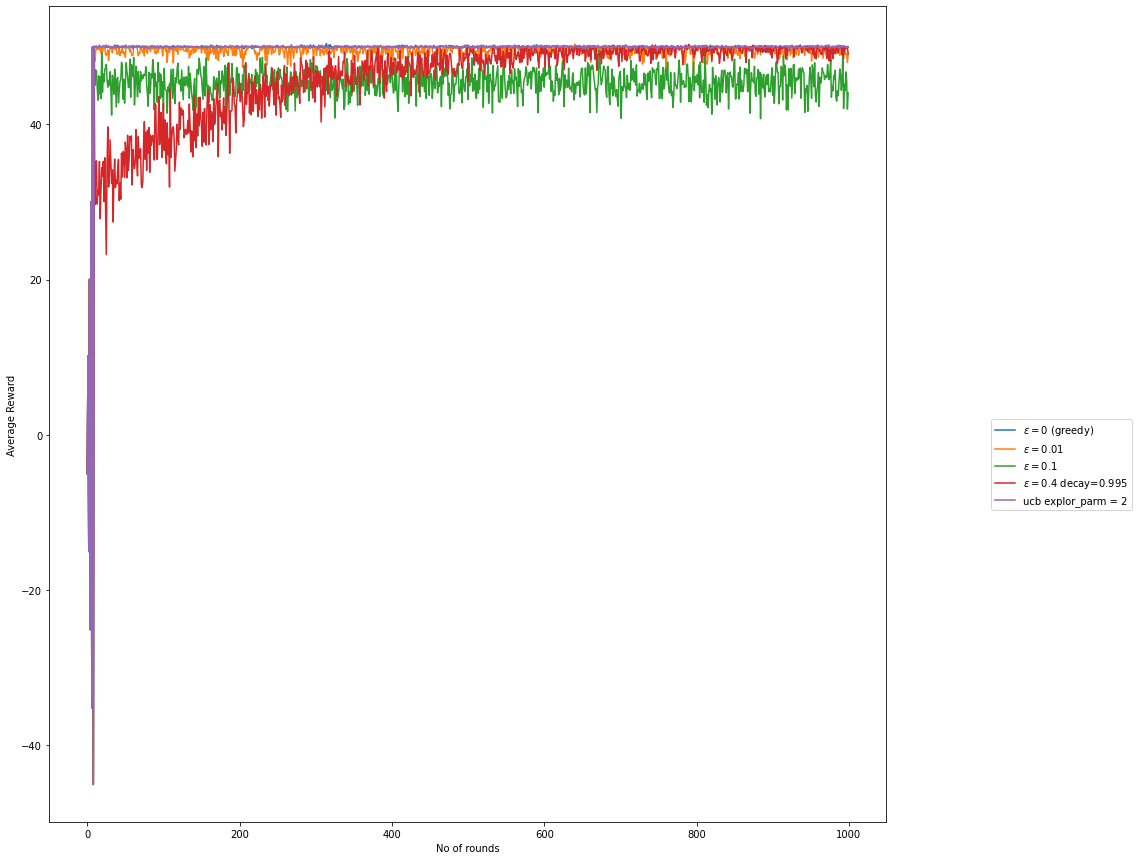

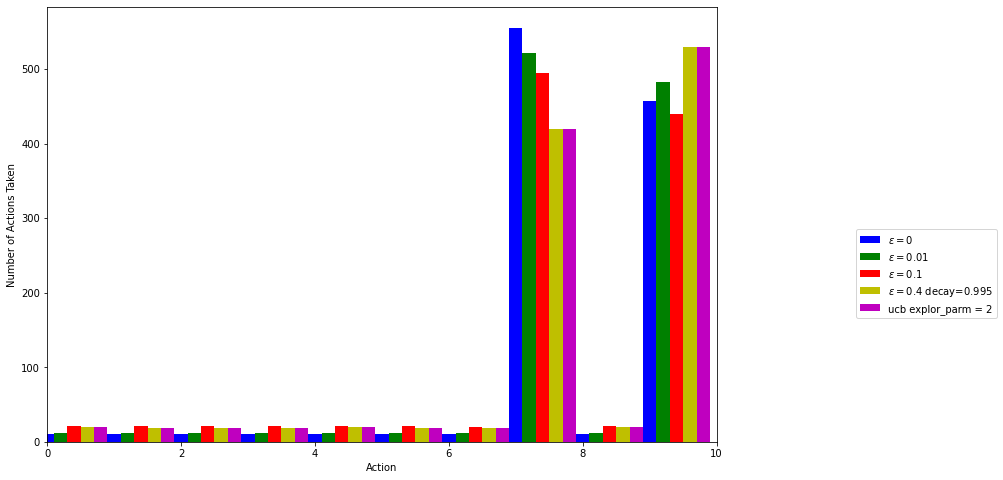

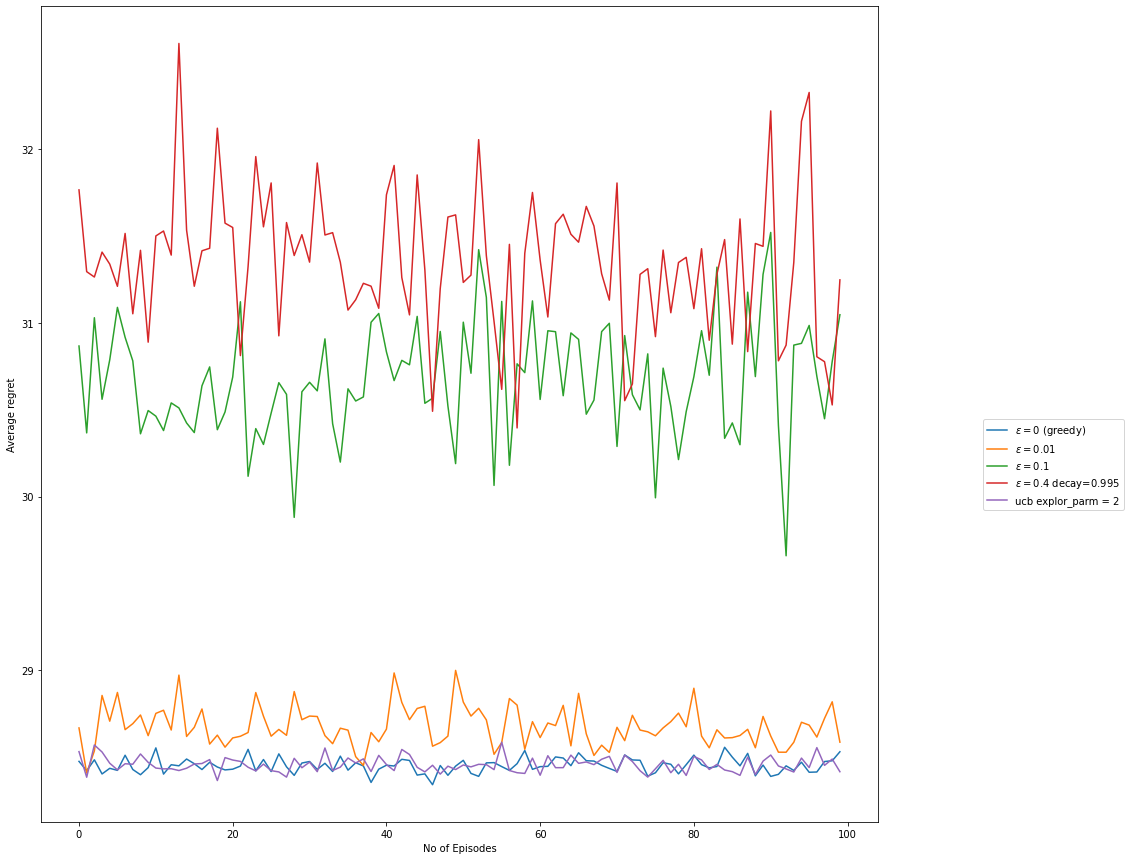

In [48]:
plt.figure(figsize=(15,15))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(eps_decay_995_rewards, label="$\epsilon=0.4$ decay=0.995")
plt.plot(ucb_rewards, label="ucb explor_parm = 2")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("No of rounds")
plt.ylabel("Average Reward")
plt.show()

bins = np.linspace(0, k-1, k)
plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, width = 0.2, color='b', label="$\epsilon=0$")
plt.bar(bins+0.2, eps_01_selection, width=0.2, color='g', label="$\epsilon=0.01$")
plt.bar(bins+0.4, eps_1_selection, width=0.2, color='r', label="$\epsilon=0.1$")
plt.bar(bins+0.6, eps_decay_995_selection, width=0.2, color='y', label="$\epsilon=0.4$ decay=0.995")
plt.bar(bins+0.8, eps_decay_995_selection, width=0.2, color='m', label="ucb explor_parm = 2")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

plt.figure(figsize=(15,15))
plt.plot(eps_0_regrets, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_regrets, label="$\epsilon=0.01$")
plt.plot(eps_1_regrets, label="$\epsilon=0.1$")
plt.plot(eps_decay_995_regrets, label="$\epsilon=0.4$ decay=0.995")
plt.plot(ucb_regrets, label="ucb explor_parm = 2")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("No of Episodes")
plt.ylabel("Average regret")
plt.show()

For ucb1 and other algorithm as well we can see that the arm number 8 pick count has increased from what it was previously and the arm number 10 has most pick count for best algorithm like epsilon with decay and ucb.